In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile

%matplotlib inline
mpl.rcParams['figure.dpi'] = 400

In [2]:
dados = pd.read_csv('Data/chapter_1_clean_dataset.csv')
dados

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0,university,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26659,ecff42d0-bdc6,220000,1,3,1,39,0,0,0,0,...,5003,3047,5000,1000,0,high school,0,1,0,0
26660,99d1fa0e-222b,150000,1,3,2,43,-1,-1,-1,-1,...,8998,129,0,0,0,high school,0,1,0,0
26661,95cdd3e7-4f24,30000,1,2,2,37,4,3,2,-1,...,22000,4200,2000,3100,1,university,0,0,0,1
26662,00d03f02-04cd,80000,1,3,1,41,1,-1,0,0,...,1178,1926,52964,1804,1,high school,0,1,0,0


Nesse capítulo será estudada a fundo a regressão logística que, apesar do nome, atua principalmente como um classificador. O objetivo aqui é utilizar os dados que já estão sendo trabalhados como ponto de partida da análise, fazendo algumas explorações a título de melhor compreensão e aprimoramento dos dados de entrada para, logo depois, utilizarmos o regressor logístico e estudar seu comportamento a fundo.

In [3]:
features_response = dados.columns.tolist()
print(features_response[:5])
print(features_response[-5:])

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']
['EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']


Aqui serão removidas algumas variáveis que não apresentam informações que possam ser úteis para nosso modelo (como as informações de pagamento de 2 à 6 e ID), as que estão em duplicidade (como as originárias do OHC) e as que possuem algum tipo de limitação ética (como o gênero). Com isso removido, teremos uma tabela com dados melhores de serem trabalhados, assim como dados mais acurados e responsáveis eticamente.

In [4]:
variaveis_a_remover = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT', 'graduate school', 'high school', 'none', 'others', 'university']
features_response = [item for item in features_response if item not in variaveis_a_remover]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

Aqui temos uma tabela de correlação. Essa tabela nos mostra as taxas de correlação entre as diversas variáveis do nosso dataset. Taxas próximas a 1 indicam forte correlação positiva (ou seja, se uma variável crescer, a outra tbm irá); taxas próximas a -1 indicam forte correlação negativa (ou seja, se uma variável crescer, a outra irá diminuir); e taxas próximas a 0 indicam que não há correlação (o comportamente de uma variável não tem correlação com o comportamento da outra variável). Essa correlação usada aqui é a correlação de Pearson.

Logo abaixo temos um mapa de calor dessa tabela de correlação, mostrando de um modo mais agradável visualmente como as variáveis em questão estão relacionadas. Como esperado, a diagonal principal possui correlação 1 para todas as variáveis, pois ela está mostrando a relação de uma variável com ela mesma.

In [5]:
corr = dados[features_response].corr()
corr.iloc[0:5, 0:5]

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000


<AxesSubplot:>

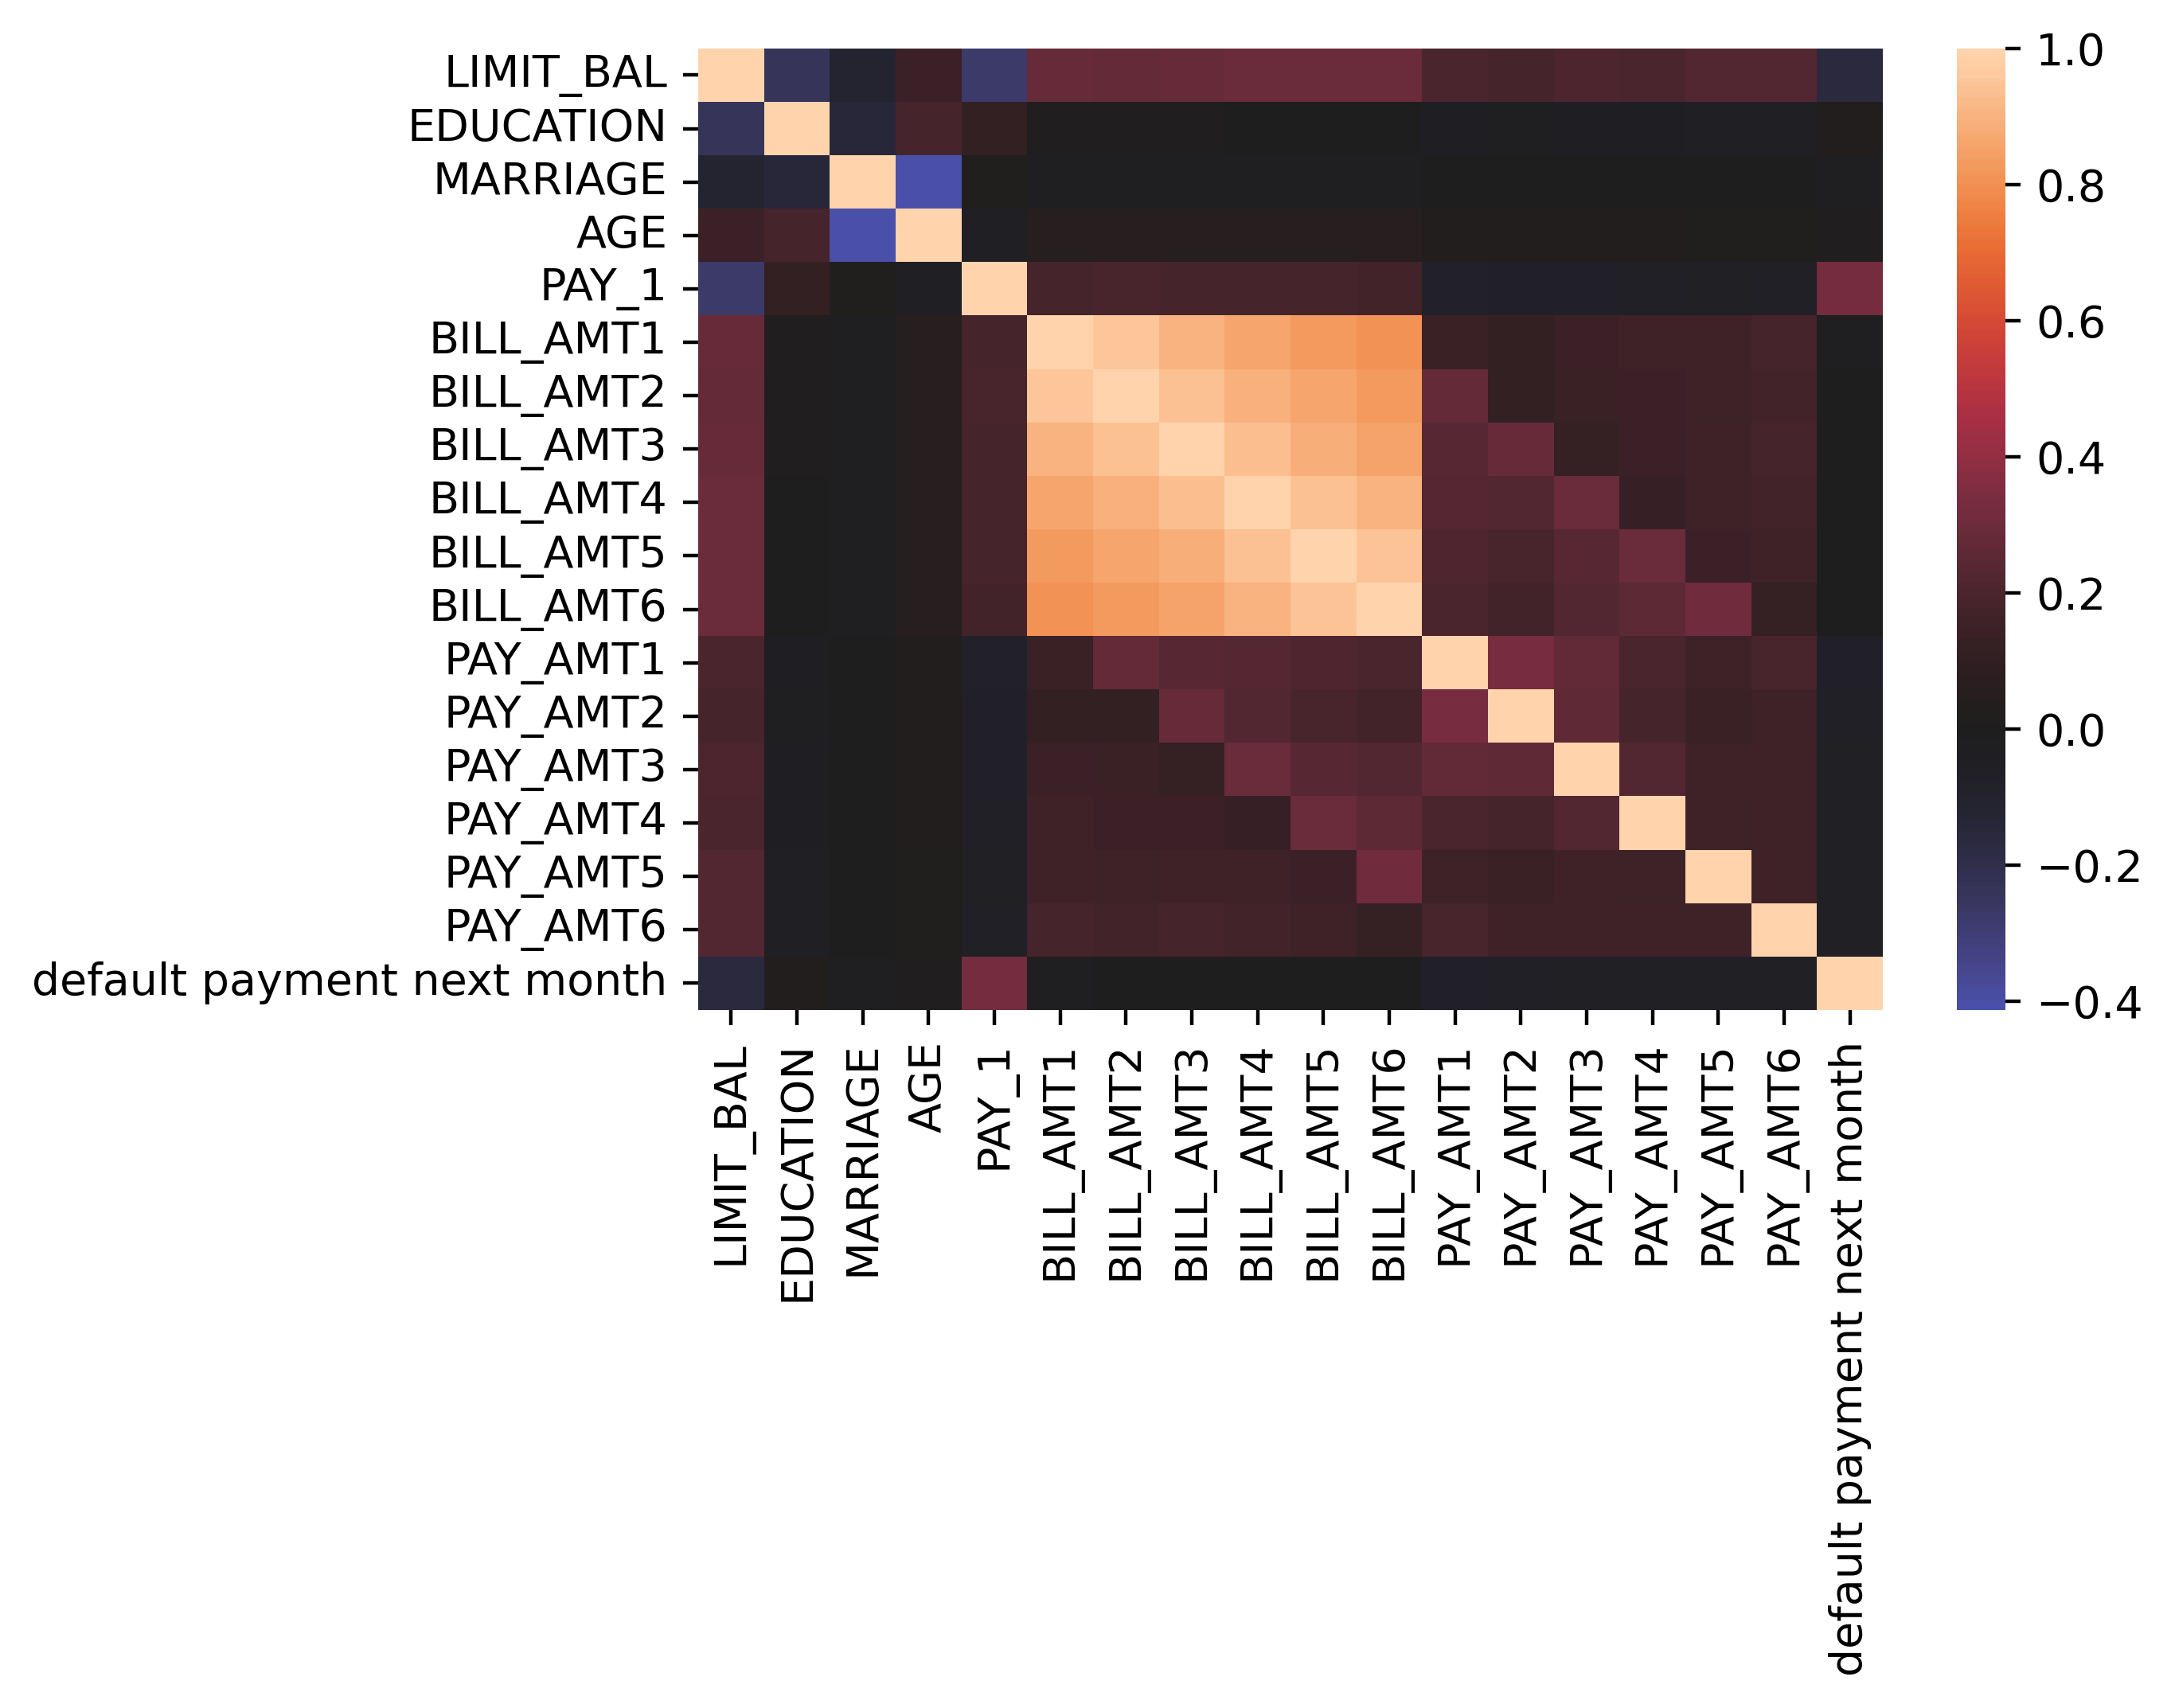

In [6]:
sns.heatmap(corr,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            center = 0)

Nessa etapa do modelo, faremos algumas análises estatísticas utilizando o valor-p e o teste f ANOVA para verificar as relações entre as variáveis e os dados que temos.

O valor-p é uma medida estatística que visa, nesse contexto, responder a seguinte pergunta: "Qual a probabilidade de o valor da média dessa característica nas amostras da classe positiva ser igual ao de amostras da classe negativa?" Ou seja, com esse valor podemos distinguir no nosso modelo as classes positivas e negativas caso o valor-p seja baixo o suficiente.

Esse cálculo é parte de um processo de seleção de características univariadas. Essa seleção visa escolher, dentre as muitas variáveis disponíveis, quais possuem uma relação melhor com a variável resposta (ou seja, qual que pode explicar mais facilmente e mais ricamente a variável resposta de modo independente)

In [7]:
X = dados[features_response].iloc[:,:-1].values
y = dados[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(26664, 17) (26664,)


In [8]:
[f_stat, f_p_value] = f_classif(X, y)
f_test_df = pd.DataFrame({'Feature': features_response[:-1],
                            'F statistic': f_stat,
                            'p value': f_p_value})

f_test_df.sort_values('p value')

,Feature,F statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


Aqui faremos uma seleção das características que apresentam maior correlação com nossa variável alvo. Para isso, usamos a função SelectPercecntile, passando como parâmetro a porcentagem que queremos filtrar. No nosso caso, buscamos as características que estão nos 20% mais influentes para nosso caso. O resultado é apresentado pela variável best_feature.

In [9]:
seletor = SelectPercentile(f_classif, percentile = 20)
seletor.fit(X, y)

best_feature_ix = seletor.get_support()
best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [10]:
features = features_response[:-1]
best_feature = [features[counter] for counter in range(len(features)) if best_feature_ix[counter]]
best_feature

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

Analisar esse resultado é simples: as variáveis com maior correlação com a variável resposta são LIMIT_BAL, PAY_1, PAY_AMT1 e PAY_AMT2. LIMIT_BAL é uma variável que diz sobre o limite da conta do cliente. Por isso, ela é uma variável de duas mãos: clientes que costumem pagar em dia suas dívidas possuem limite maior e clientes com limite maior geralmente possuem renda maior e, por isso, são mais propícios a pagarem suas contas. Ou seja, de todo modo, maior limite tende a indicar maior probabilidade de pagar a conta daquele mês.

Já a variável PAY_1, como visto anteriormente, é uma variável que indica se houve o pagamento da fatura anterior. Um valor de -2 indica que a conta não foi usada, -1 indica saldo anterior totalmente quitado, 0 indica que o pagamento mínimo foi feito e qualquer valor diferente disso indica um valor que um valor parcial foi pago e quanto foi esse valor. Por isso é natural vermos que o valor do histórico recente de pagamento está fortemente associado ao pagamento da fatura desse mês. Essa lógica também se aplica às outras duas variáveis, PAY_AMT1 e PAY_AMT2.

Para fazer uma análise mais acurada do quão impactante um modelo baseado em uma determinada feature pode ser, precisamos ter uma média da nossa variável resposta. Como os valores possíveis são somente 0 ou 1, uma média simples pode nos mostrar uma 'linha de base' e um 'objetivo' ao nosso modelo. Quanto mais perto desse valor a média do resultado final for, mais preciso será nosso modelo.

In [11]:
overall_default_rate = dados['default payment next month'].mean()
overall_default_rate

0.2217971797179718

In [12]:
group_by_pay_mean_y = dados.groupby('PAY_1').agg({'default payment next month': np.mean})
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


Para uma melhor visualização dos resultados, podemos plotar a média da variável de resposta pra cada um dos grupos que compõem a variável PAY_1, além do valor médio para comparação.

Essa comparação nos mostra, por exemplo, que entre os clientes com PAY_1 igual a -2, -1 e 0, a média de pagamento é bem próxima da média geral, ligeiramente inferior. Para os outros casos, a média é bastente superior, indicando maior inadimplência.

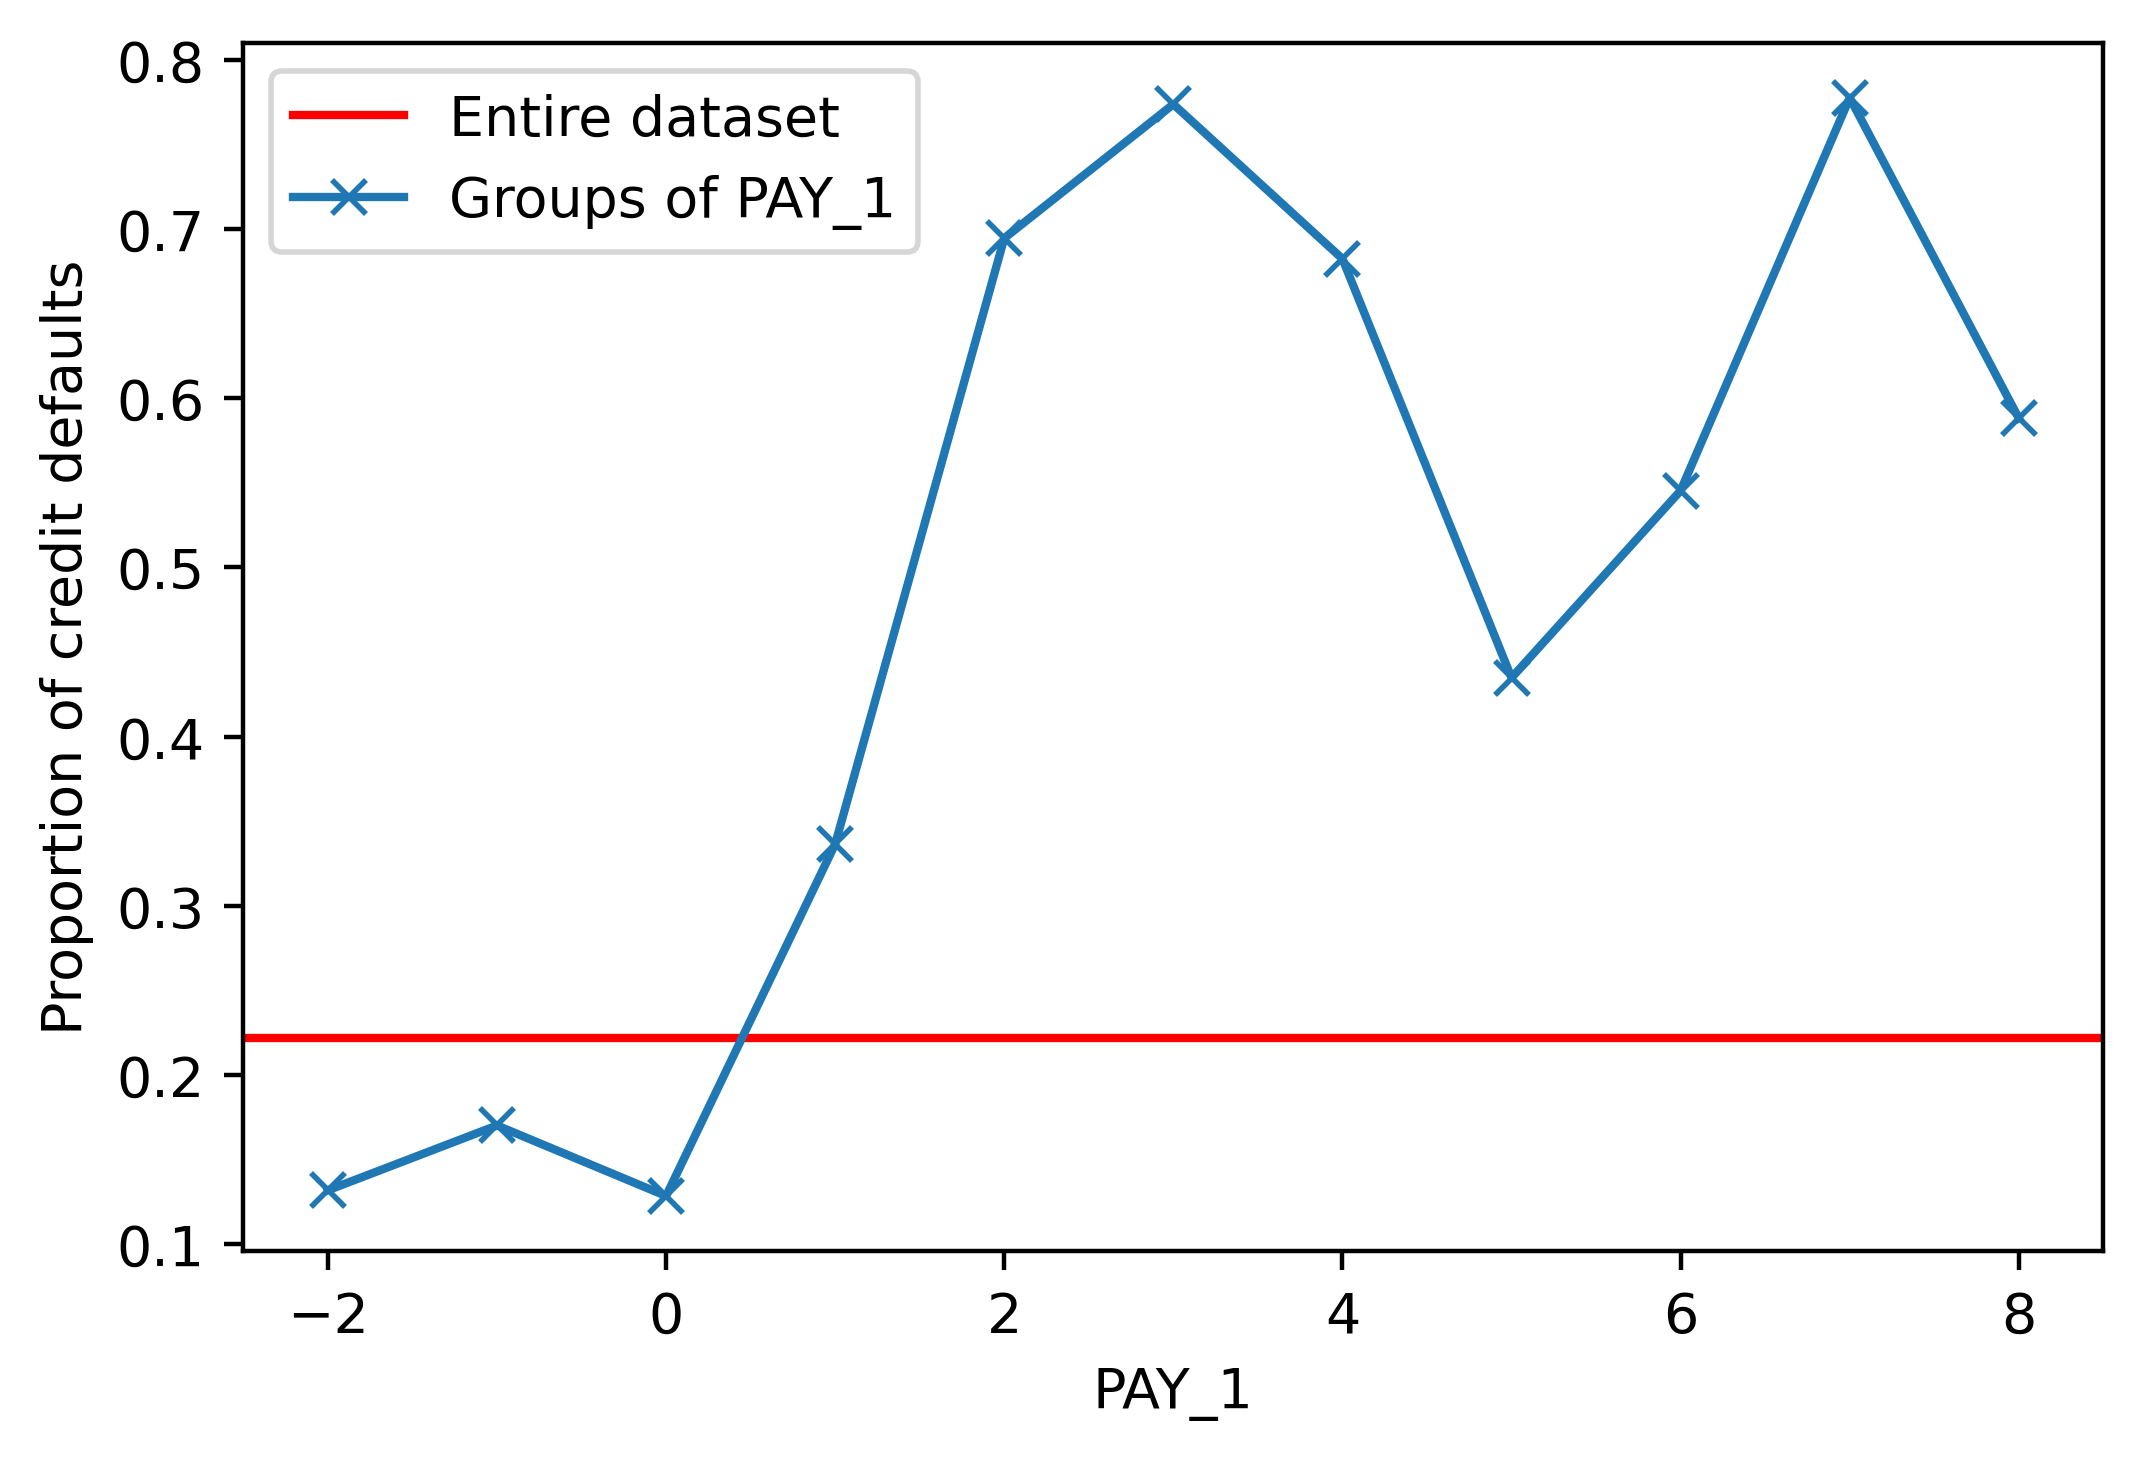

In [13]:
axes = plt.axes()
axes.axhline(overall_default_rate, color = 'red')
group_by_pay_mean_y.plot(marker = 'x', legend = False, ax = axes)
axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1'])

Text(0.5, 1.0, 'Credit limits by response variable')

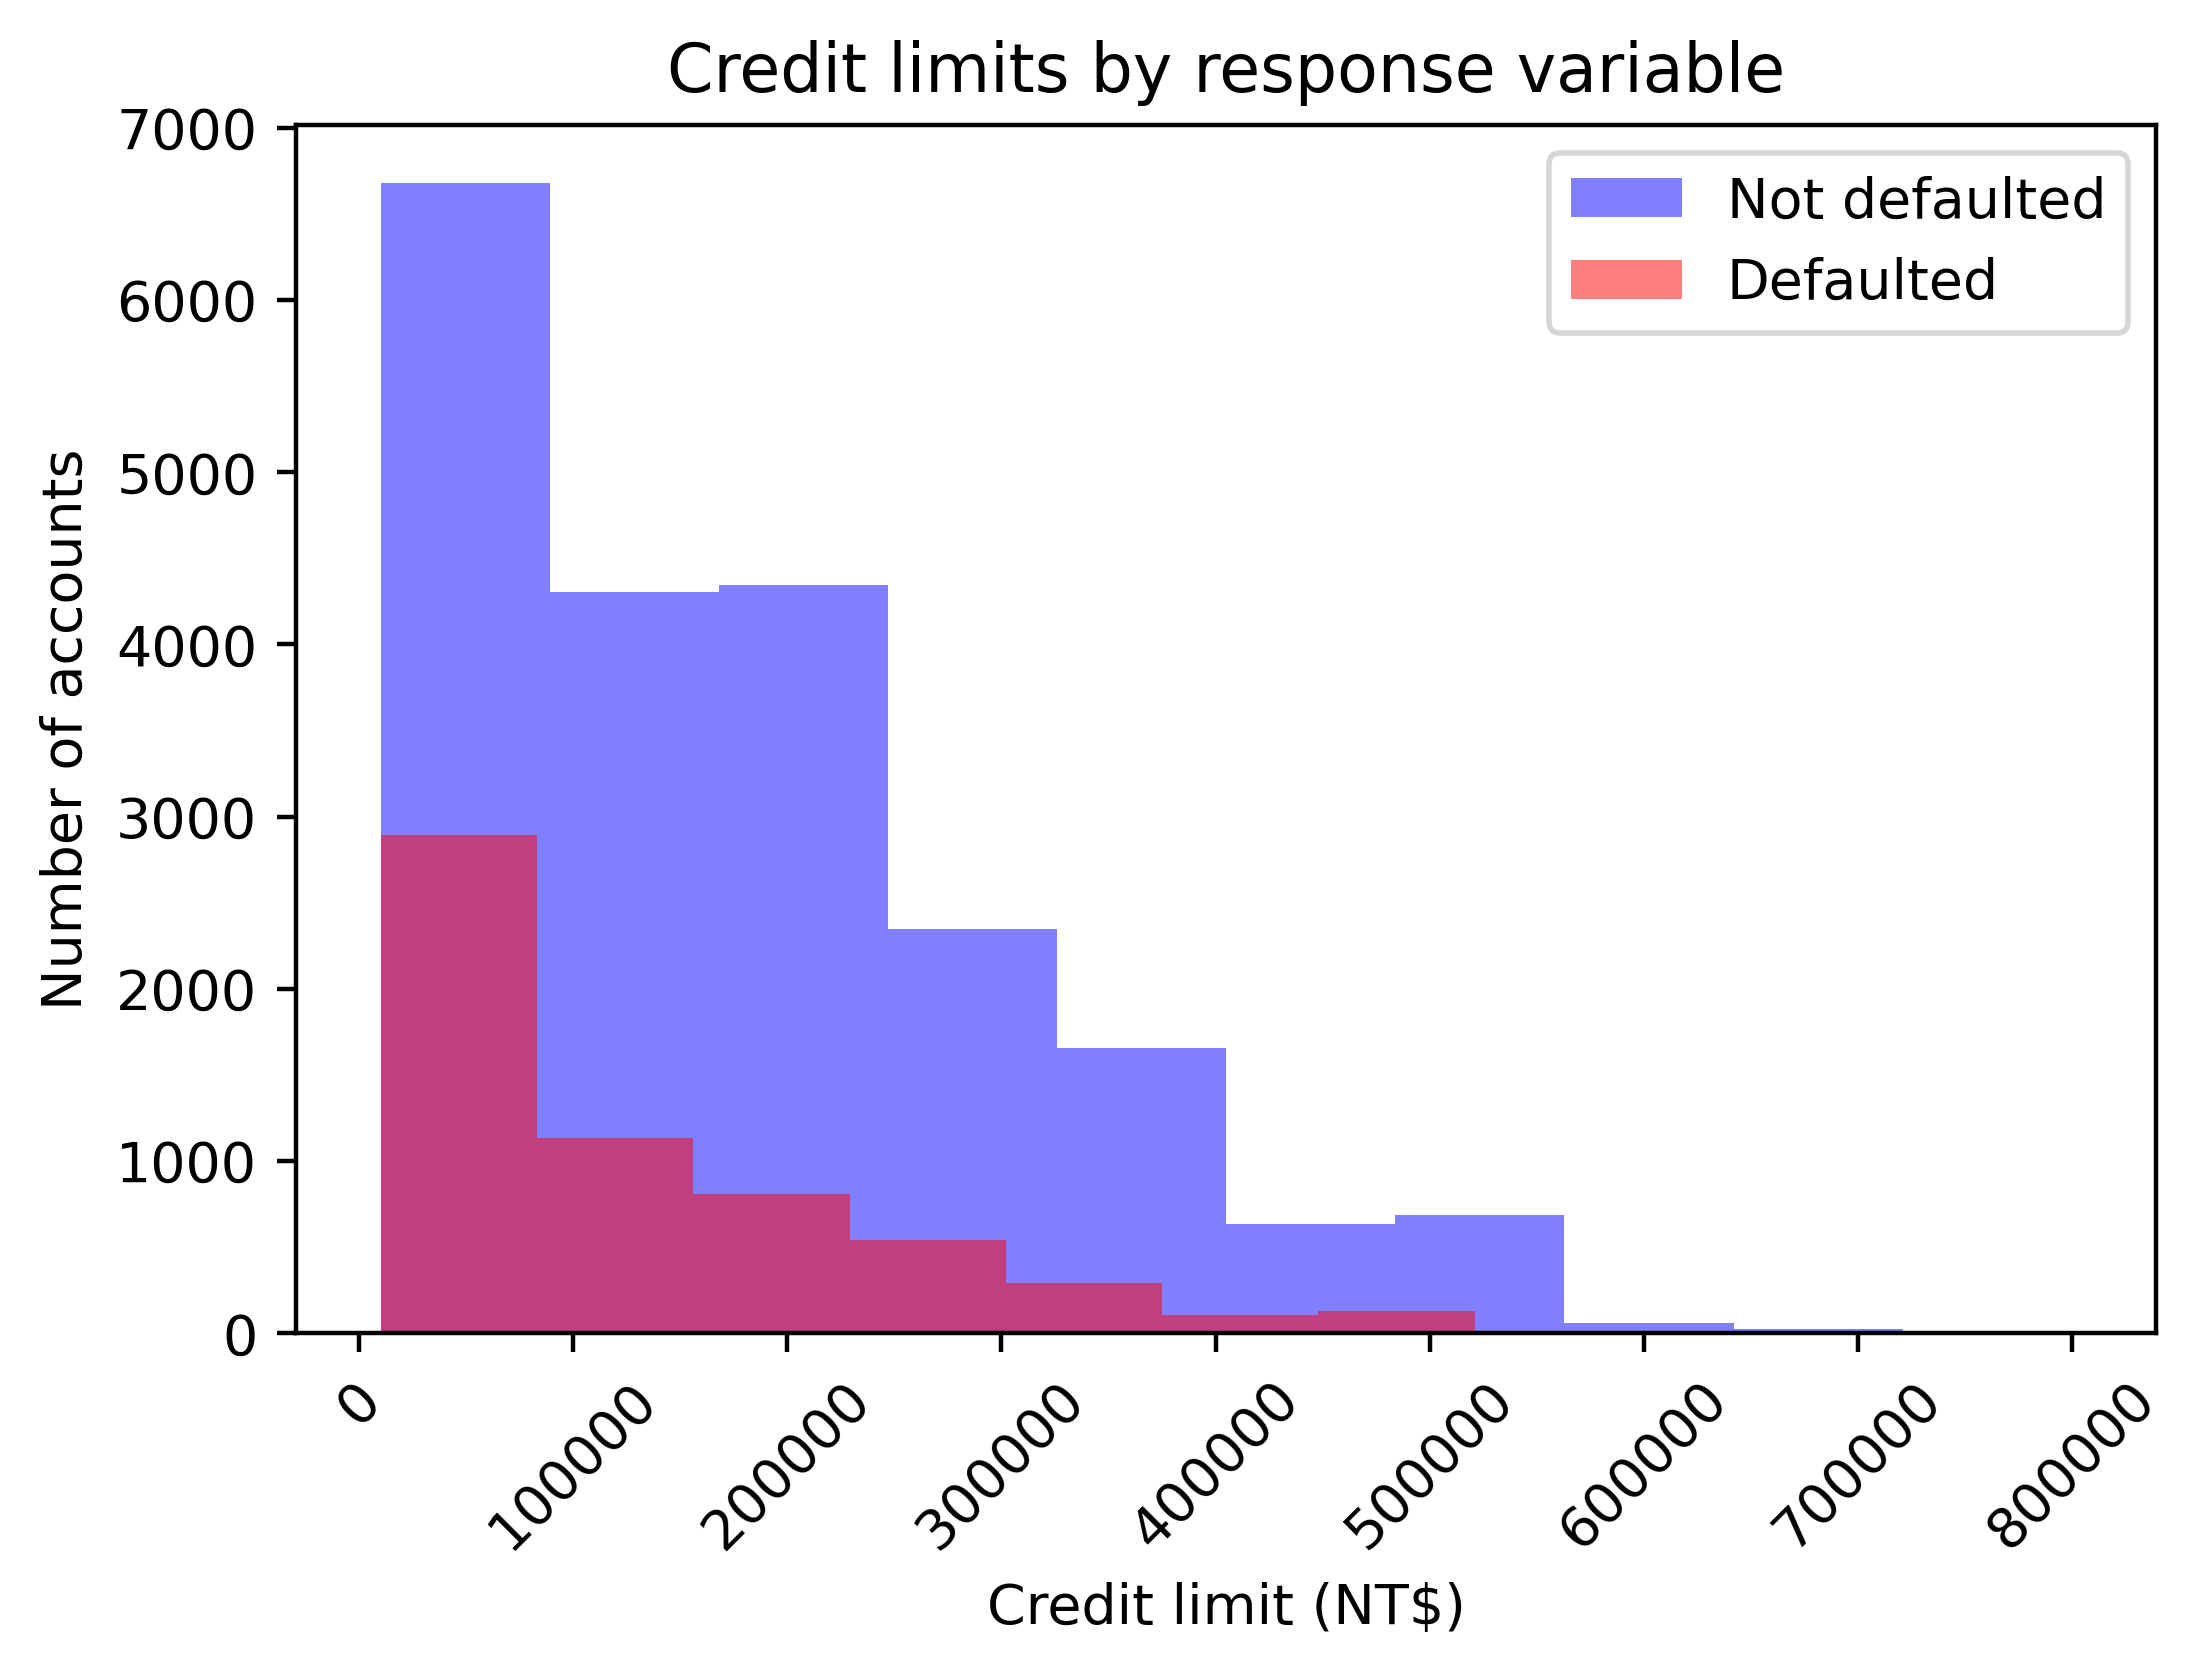

In [14]:
pos_mask = y == 1
neg_mask = y == 0

axes = plt.axes()
axes.hist(dados.loc[neg_mask, 'LIMIT_BAL'], alpha = 0.5, color = 'blue')
axes.hist(dados.loc[pos_mask, 'LIMIT_BAL'], alpha = 0.5, color = 'red')
axes.tick_params(axis = 'x', labelrotation = 45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

In [15]:
bin_edges = list(range(0, 850000, 50000))
print(bin_edges[-1])

800000


/tmp/ipykernel_112019/3673576943.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(y_ticks * 50000, 2))


Text(0.5, 1.0, 'Normalized distribuition of credit limits by response variable')

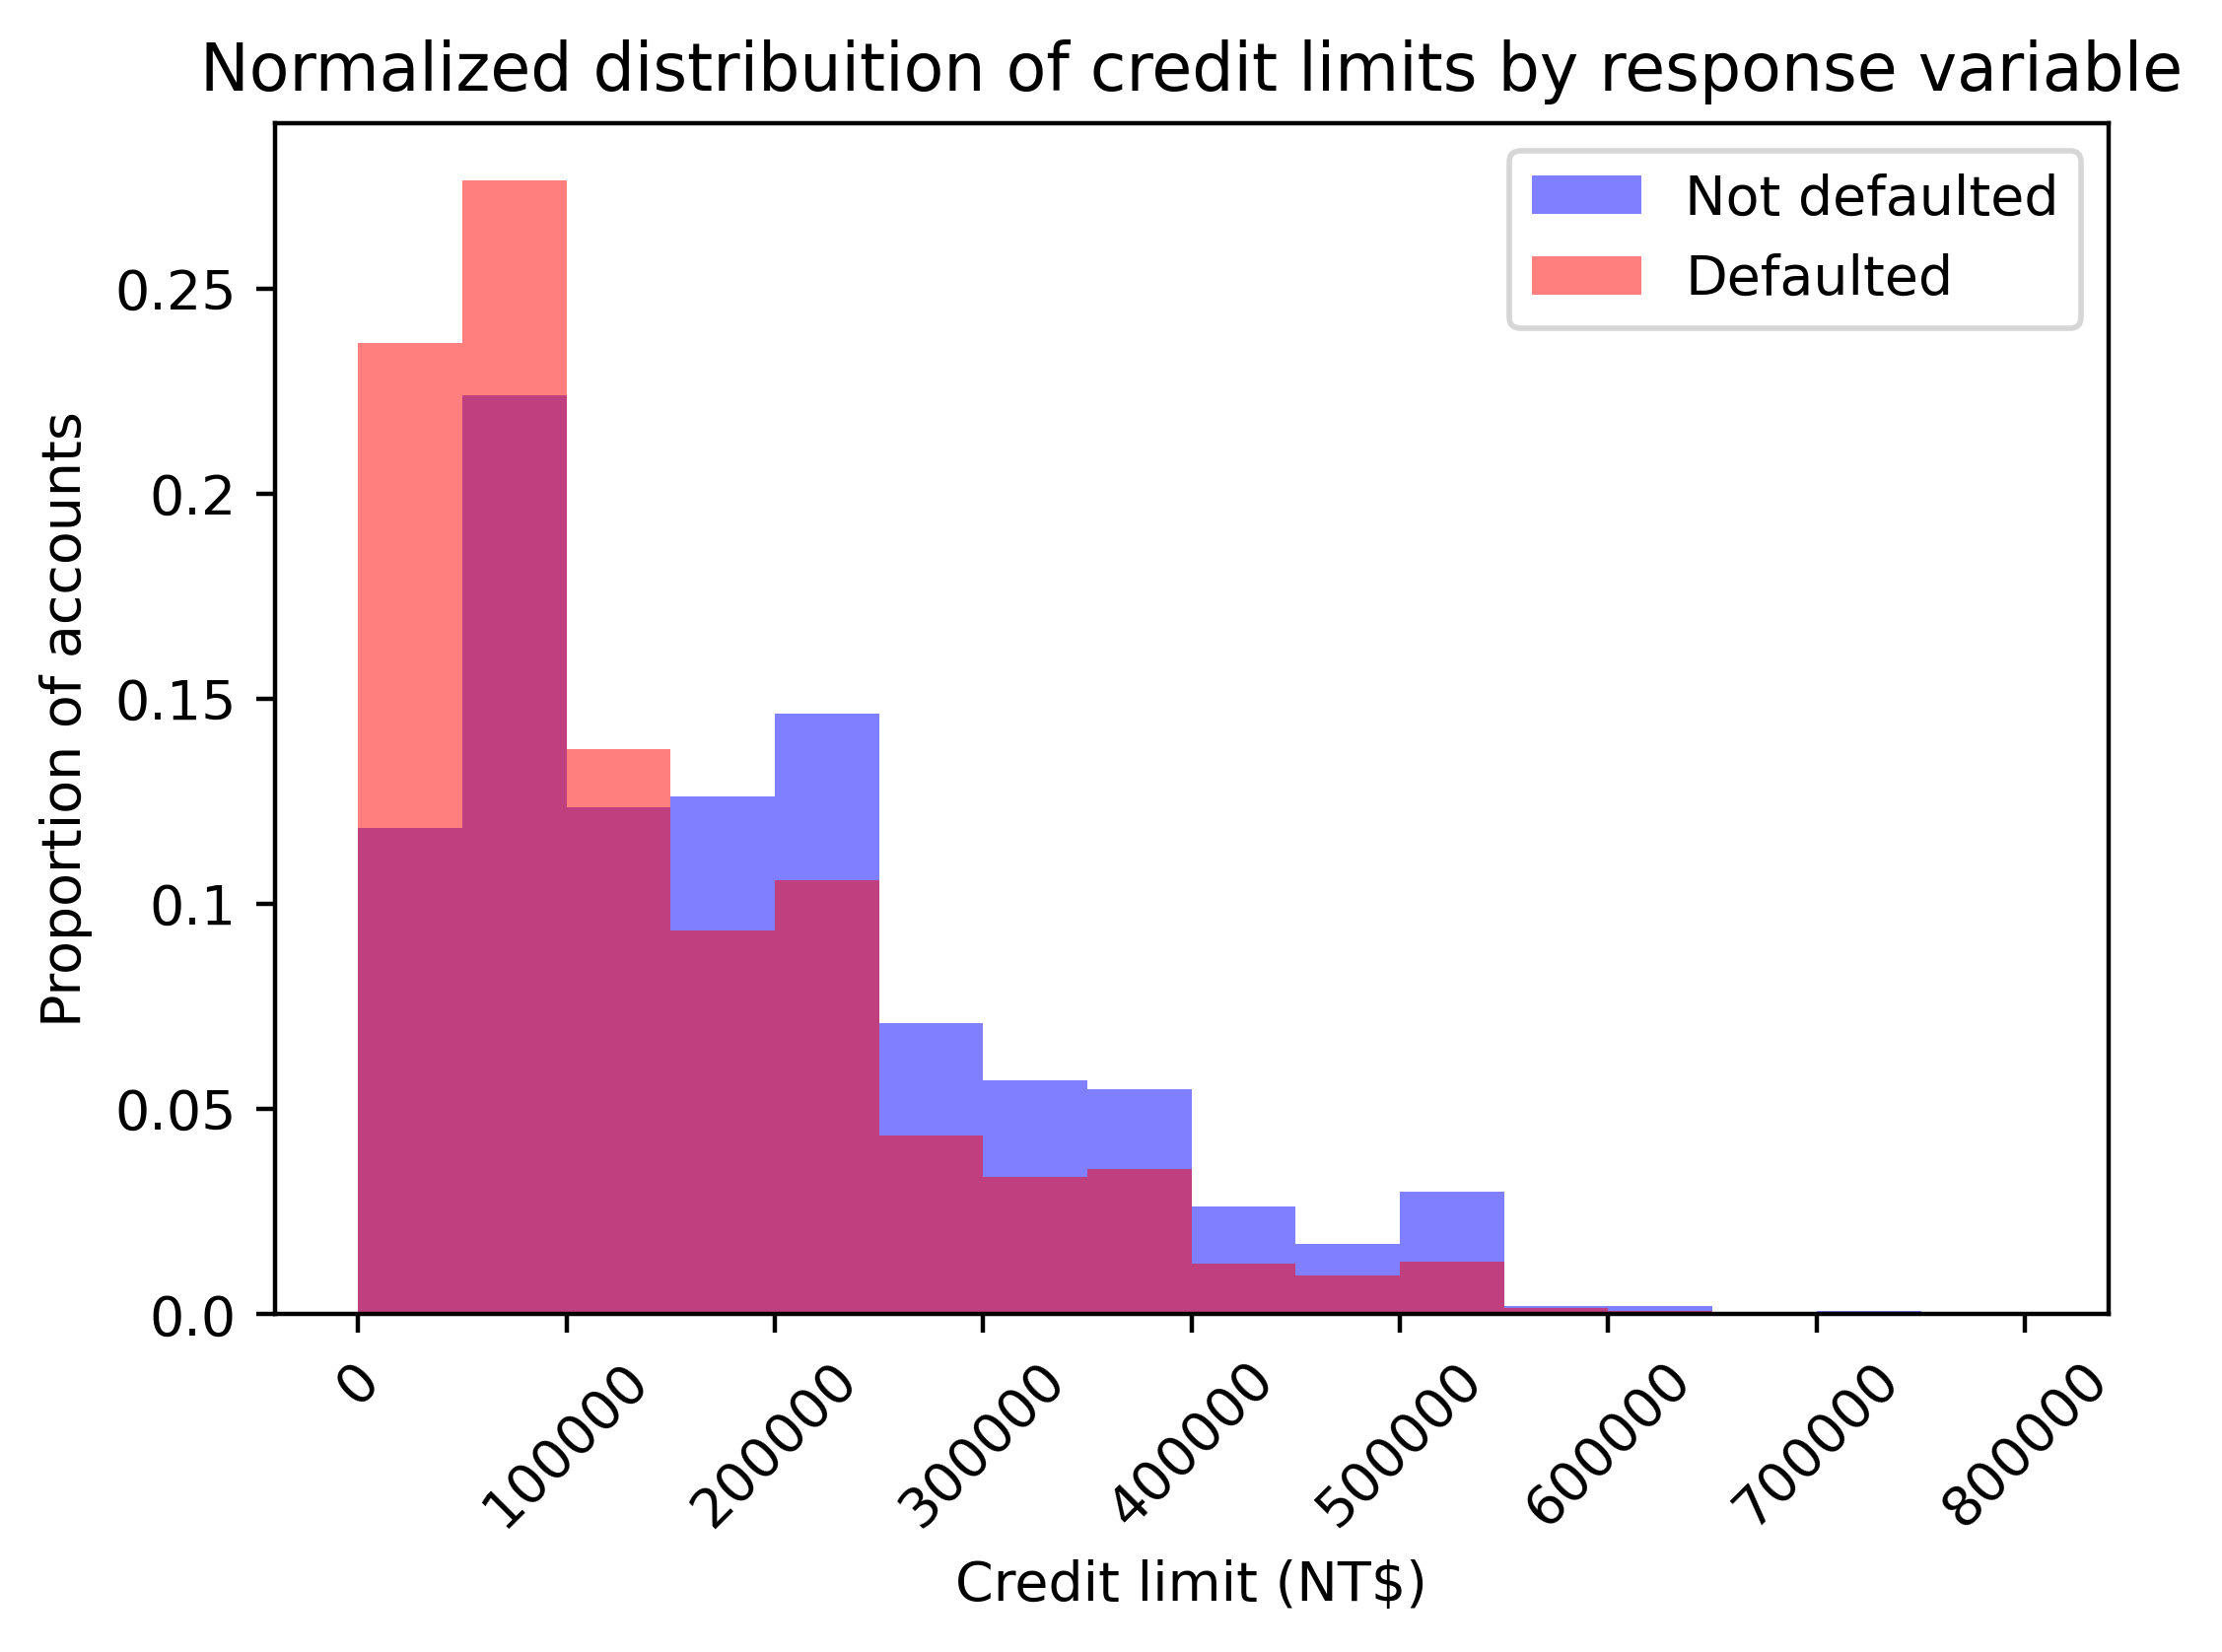

In [16]:
mpl.rcParams['figure.dpi'] = 400
axes = plt.axes()
axes.hist(dados.loc[neg_mask, 'LIMIT_BAL'], bins = bin_edges,
            alpha = 0.5, density = True, color = 'blue')
axes.hist(dados.loc[pos_mask, 'LIMIT_BAL'], bins = bin_edges,
            alpha = 0.5, density = True, color = 'red')
axes.tick_params(axis = 'x', labelrotation = 45)
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks * 50000, 2))
axes.legend(['Not defaulted', 'Defaulted'])
axes.set_title('Normalized distribuition of credit limits by response variable')

Text(0.5, 0, 'Values of PAY_1')

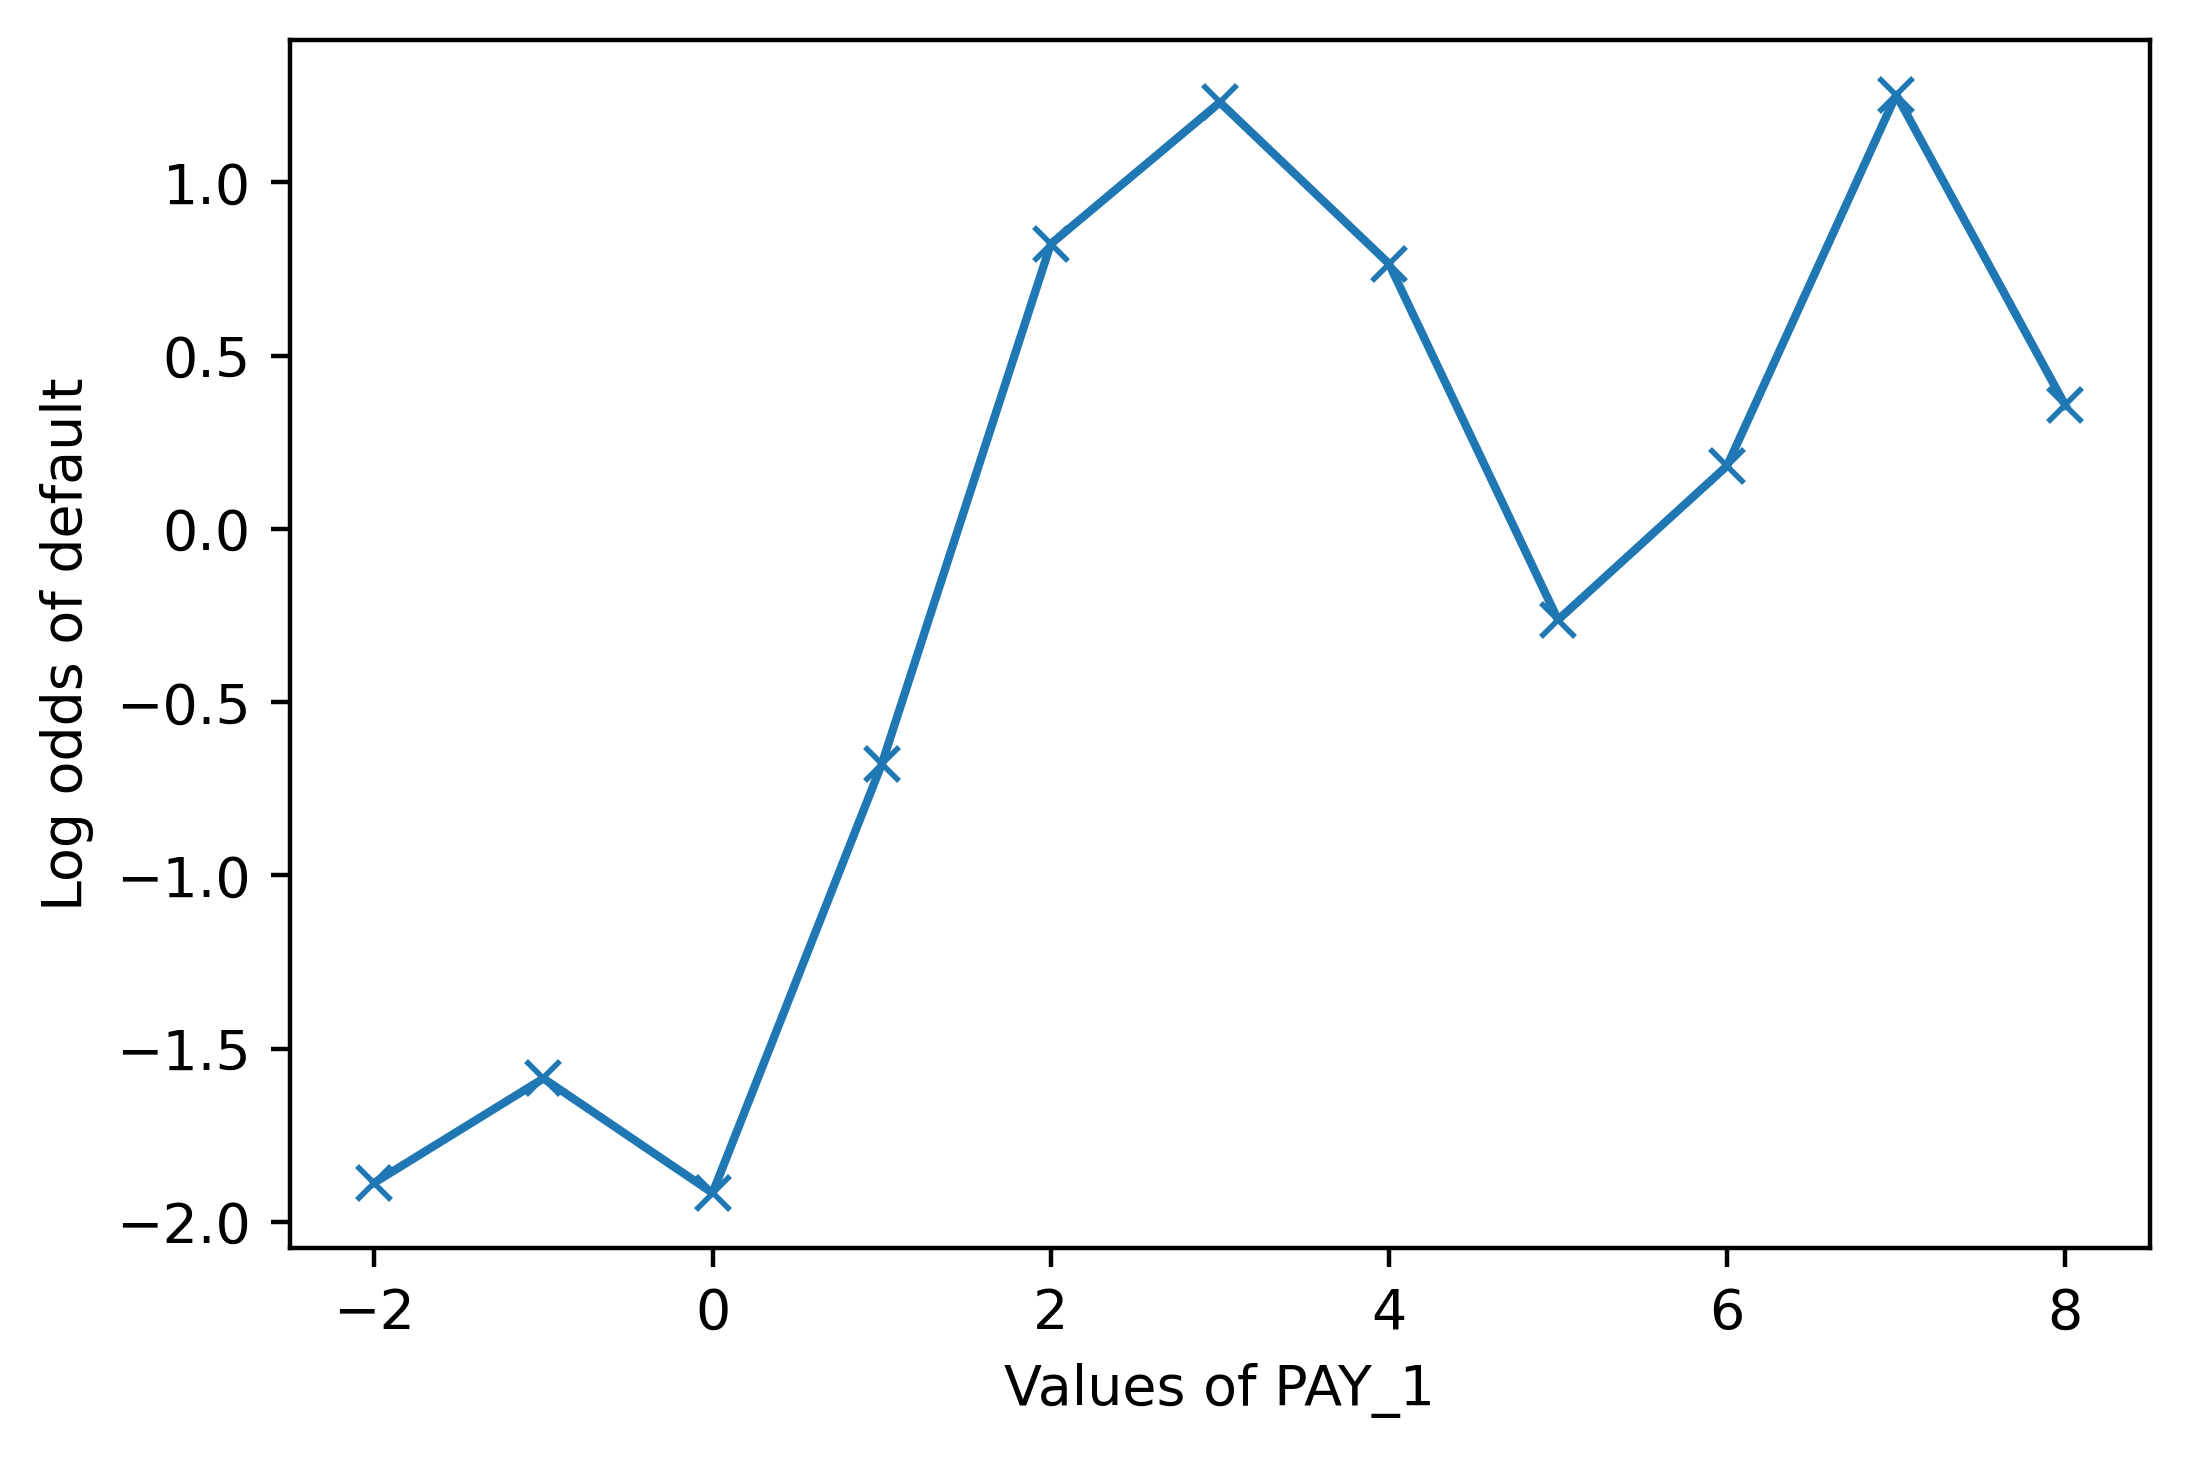

In [17]:
p = group_by_pay_mean_y['default payment next month'].values
q = 1 - p

odds_ratio = p/q
log_odds = np.log(odds_ratio)

plt.plot(group_by_pay_mean_y.index, log_odds, '-x')
plt.ylabel('Log odds of default')
plt.xlabel('Values of PAY_1')

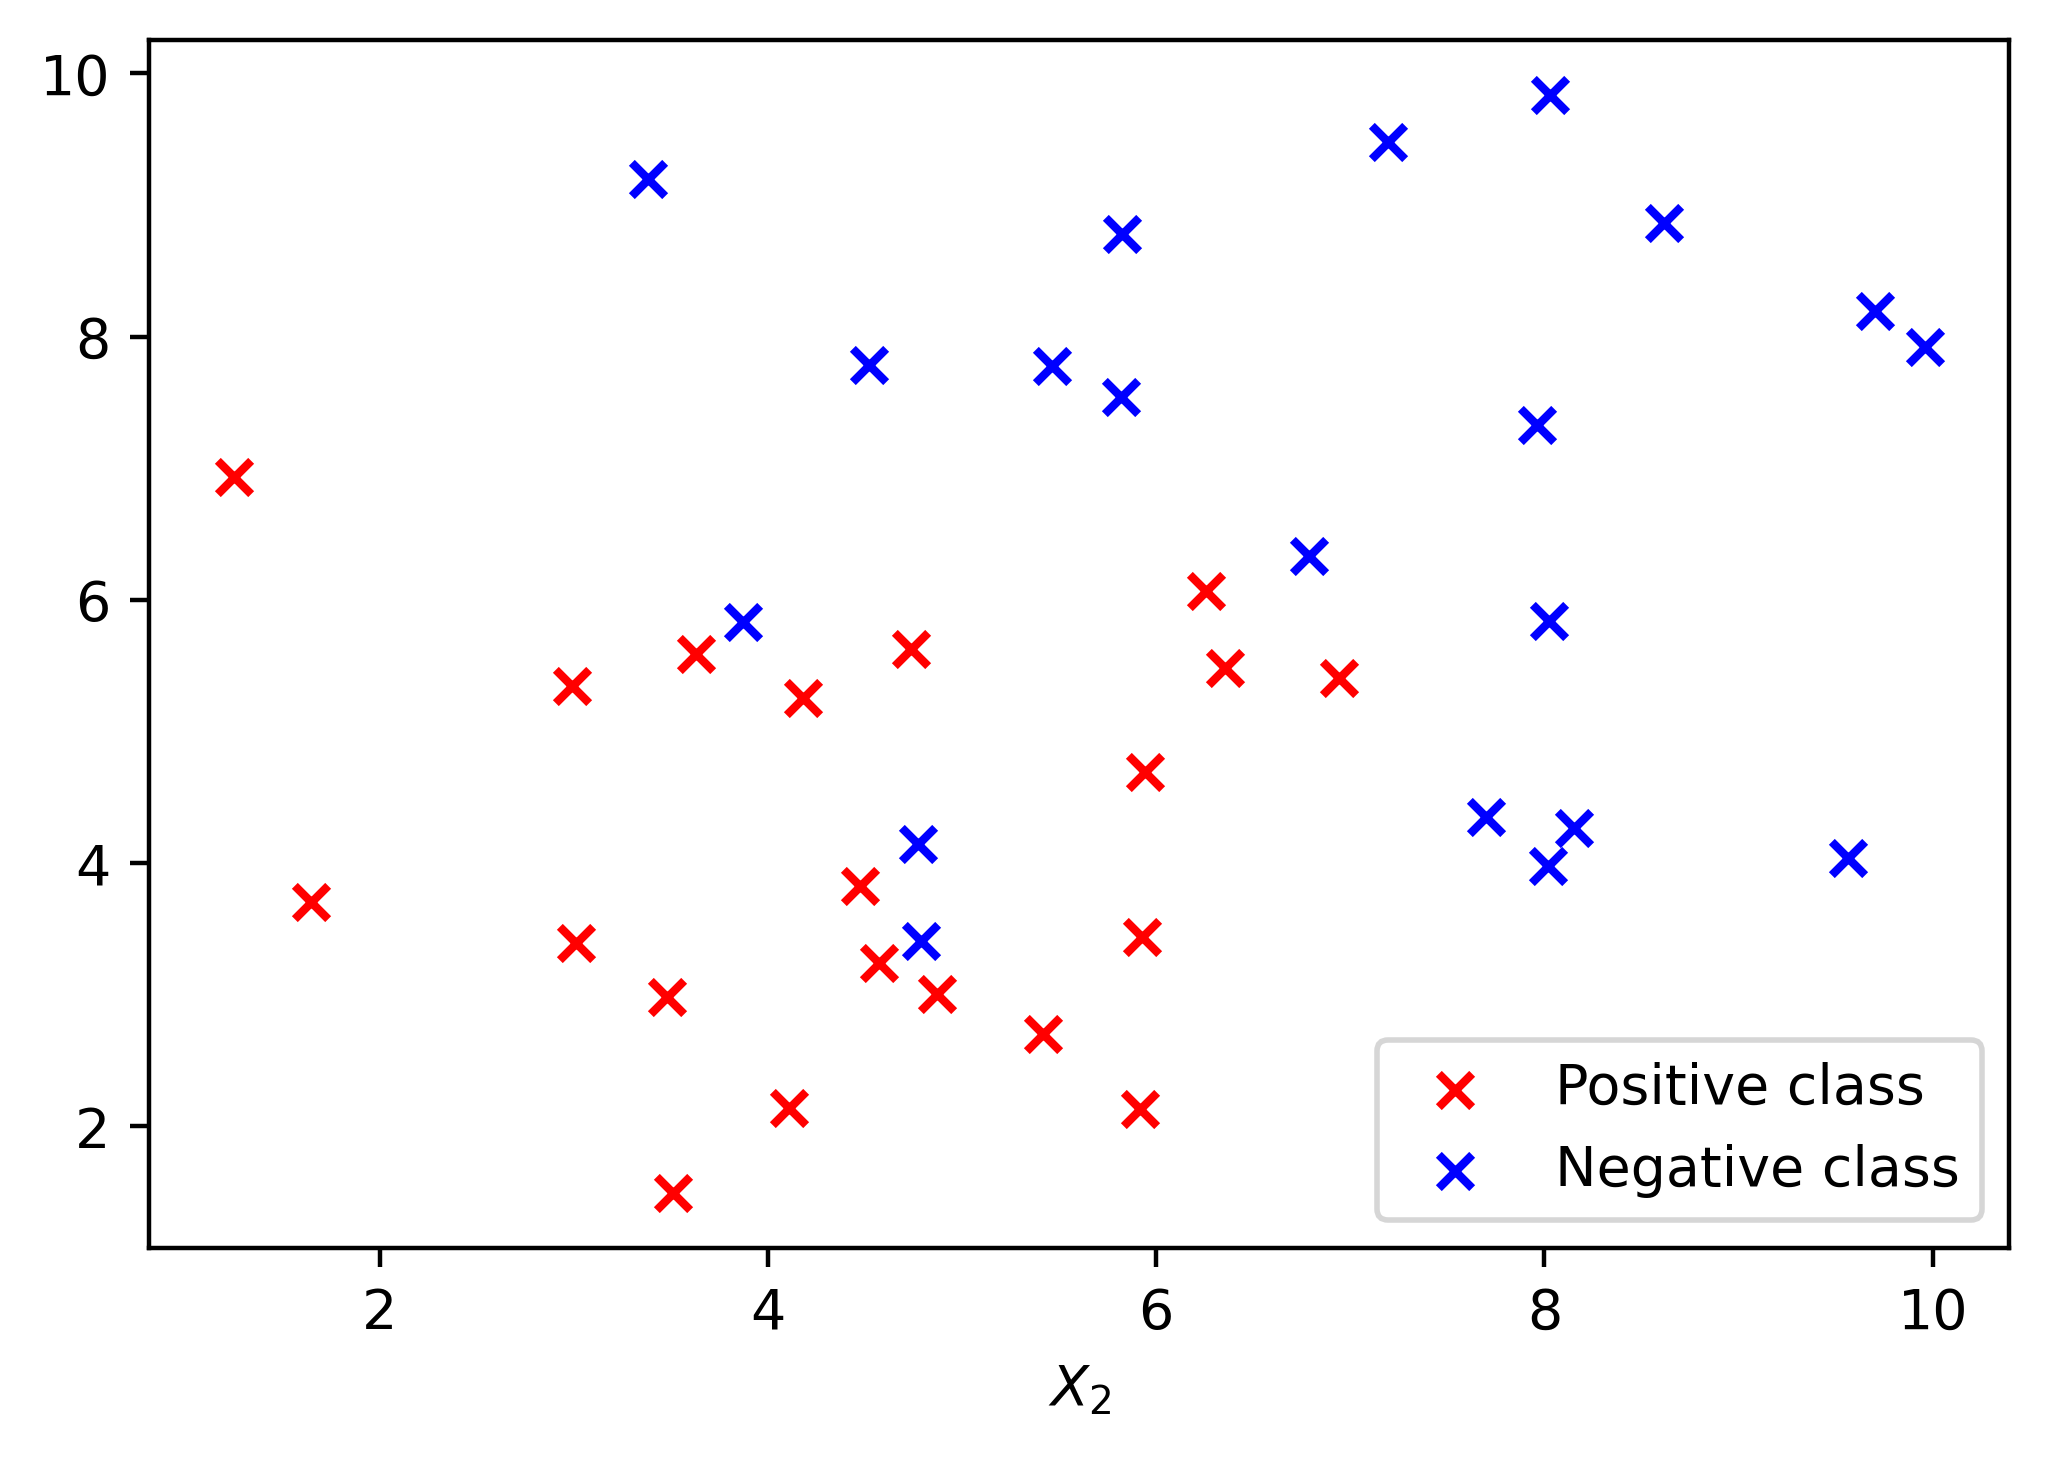

In [18]:
np.random.seed(6)
X_1_pos = np.random.uniform(low = 1, high = 7, size = (20, 1))
X_1_neg = np.random.uniform(low = 3, high = 10, size = (20, 1))
X_2_pos = np.random.uniform(low = 1, high = 7, size = (20, 1))
X_2_neg = np.random.uniform(low = 3, high = 10, size = (20, 1))

plt.scatter(X_1_pos, X_2_pos, color = 'red', marker = 'x')
plt.scatter(X_1_neg, X_2_neg, color = 'blue', marker = 'x')
plt.xlabel('$X_1$')
plt.xlabel('$X_2$')
plt.legend(['Positive class', 'Negative class'])

In [19]:
X = np.block([[X_1_pos, X_2_pos], [X_1_neg, X_2_neg]])
print(X.shape)
print(X[0:3])

(40, 2)
[[6.35716091 5.4790643 ]
 [2.99187883 5.3444234 ]
 [5.92737474 3.43664678]]


In [20]:
y = np.vstack((np.ones((20, 1)), np.zeros((20, 1)))).reshape(40,)
print(y[0:5])
print(y[-5:])

[1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0.]


In [21]:
example_lr = LogisticRegression(solver = 'liblinear')
example_lr.fit(X, y)

LogisticRegression(solver='liblinear')

In [22]:
y_pred = example_lr.predict(X)

positive_indices = [counter for counter in range(len(y_pred)) if y_pred[counter] == 1]
negative_indices = [counter for counter in range(len(y_pred)) if y_pred[counter] == 0]

positive_indices

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 32, 38]

Text(0, 0.5, '$X_2')

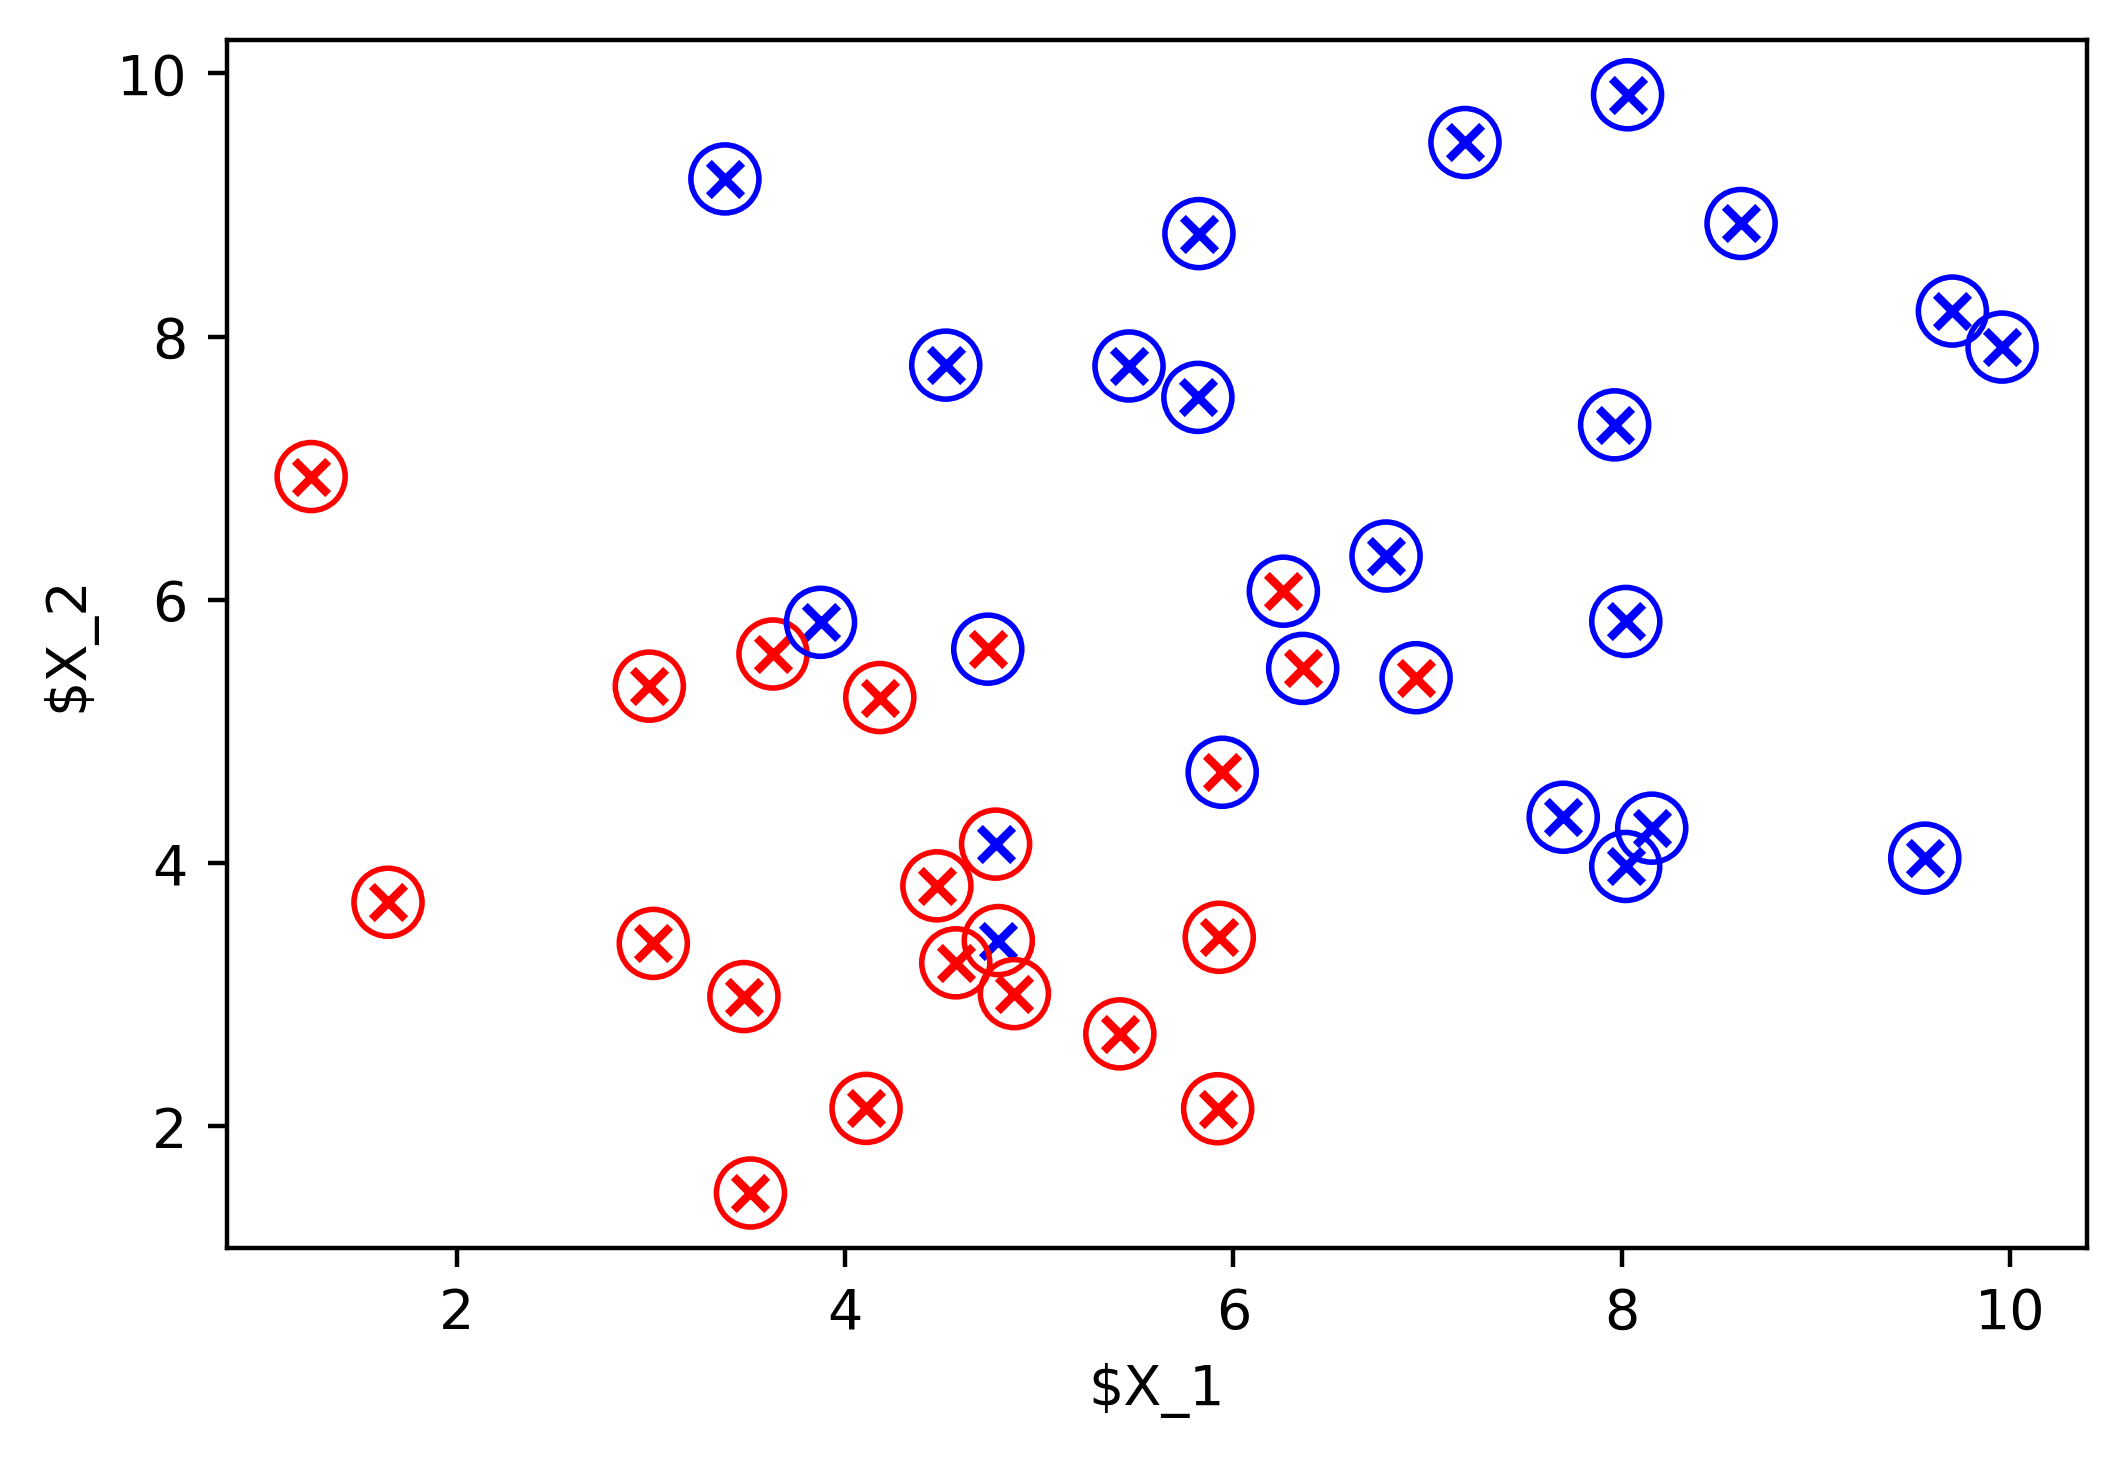

In [23]:
plt.scatter(X_1_pos, X_2_pos, color = 'red', marker = 'x')
plt.scatter(X_1_neg, X_2_neg, color = 'blue', marker = 'x')
plt.scatter(X[positive_indices, 0], X[positive_indices, 1], s = 150, marker = 'o', edgecolor = 'red', facecolors = 'none')
plt.scatter(X[negative_indices, 0], X[negative_indices, 1], s = 150, marker = 'o', edgecolor = 'blue', facecolors = 'none')

plt.xlabel('$X_1')
plt.ylabel('$X_2')

In [24]:
theta_0 = example_lr.intercept_
theta_1 = example_lr.coef_[0][0]
theta_2 = example_lr.coef_[0][1]
print(theta_0, theta_1, theta_2)

[2.25479161] -0.20245058016285838 -0.25336423626773225


In [25]:
X_1_decision_boundary = np.array([0, 10])
X_2_decision_boundary = -(theta_1/theta_2) * X_1_decision_boundary - (theta_0/theta_2)

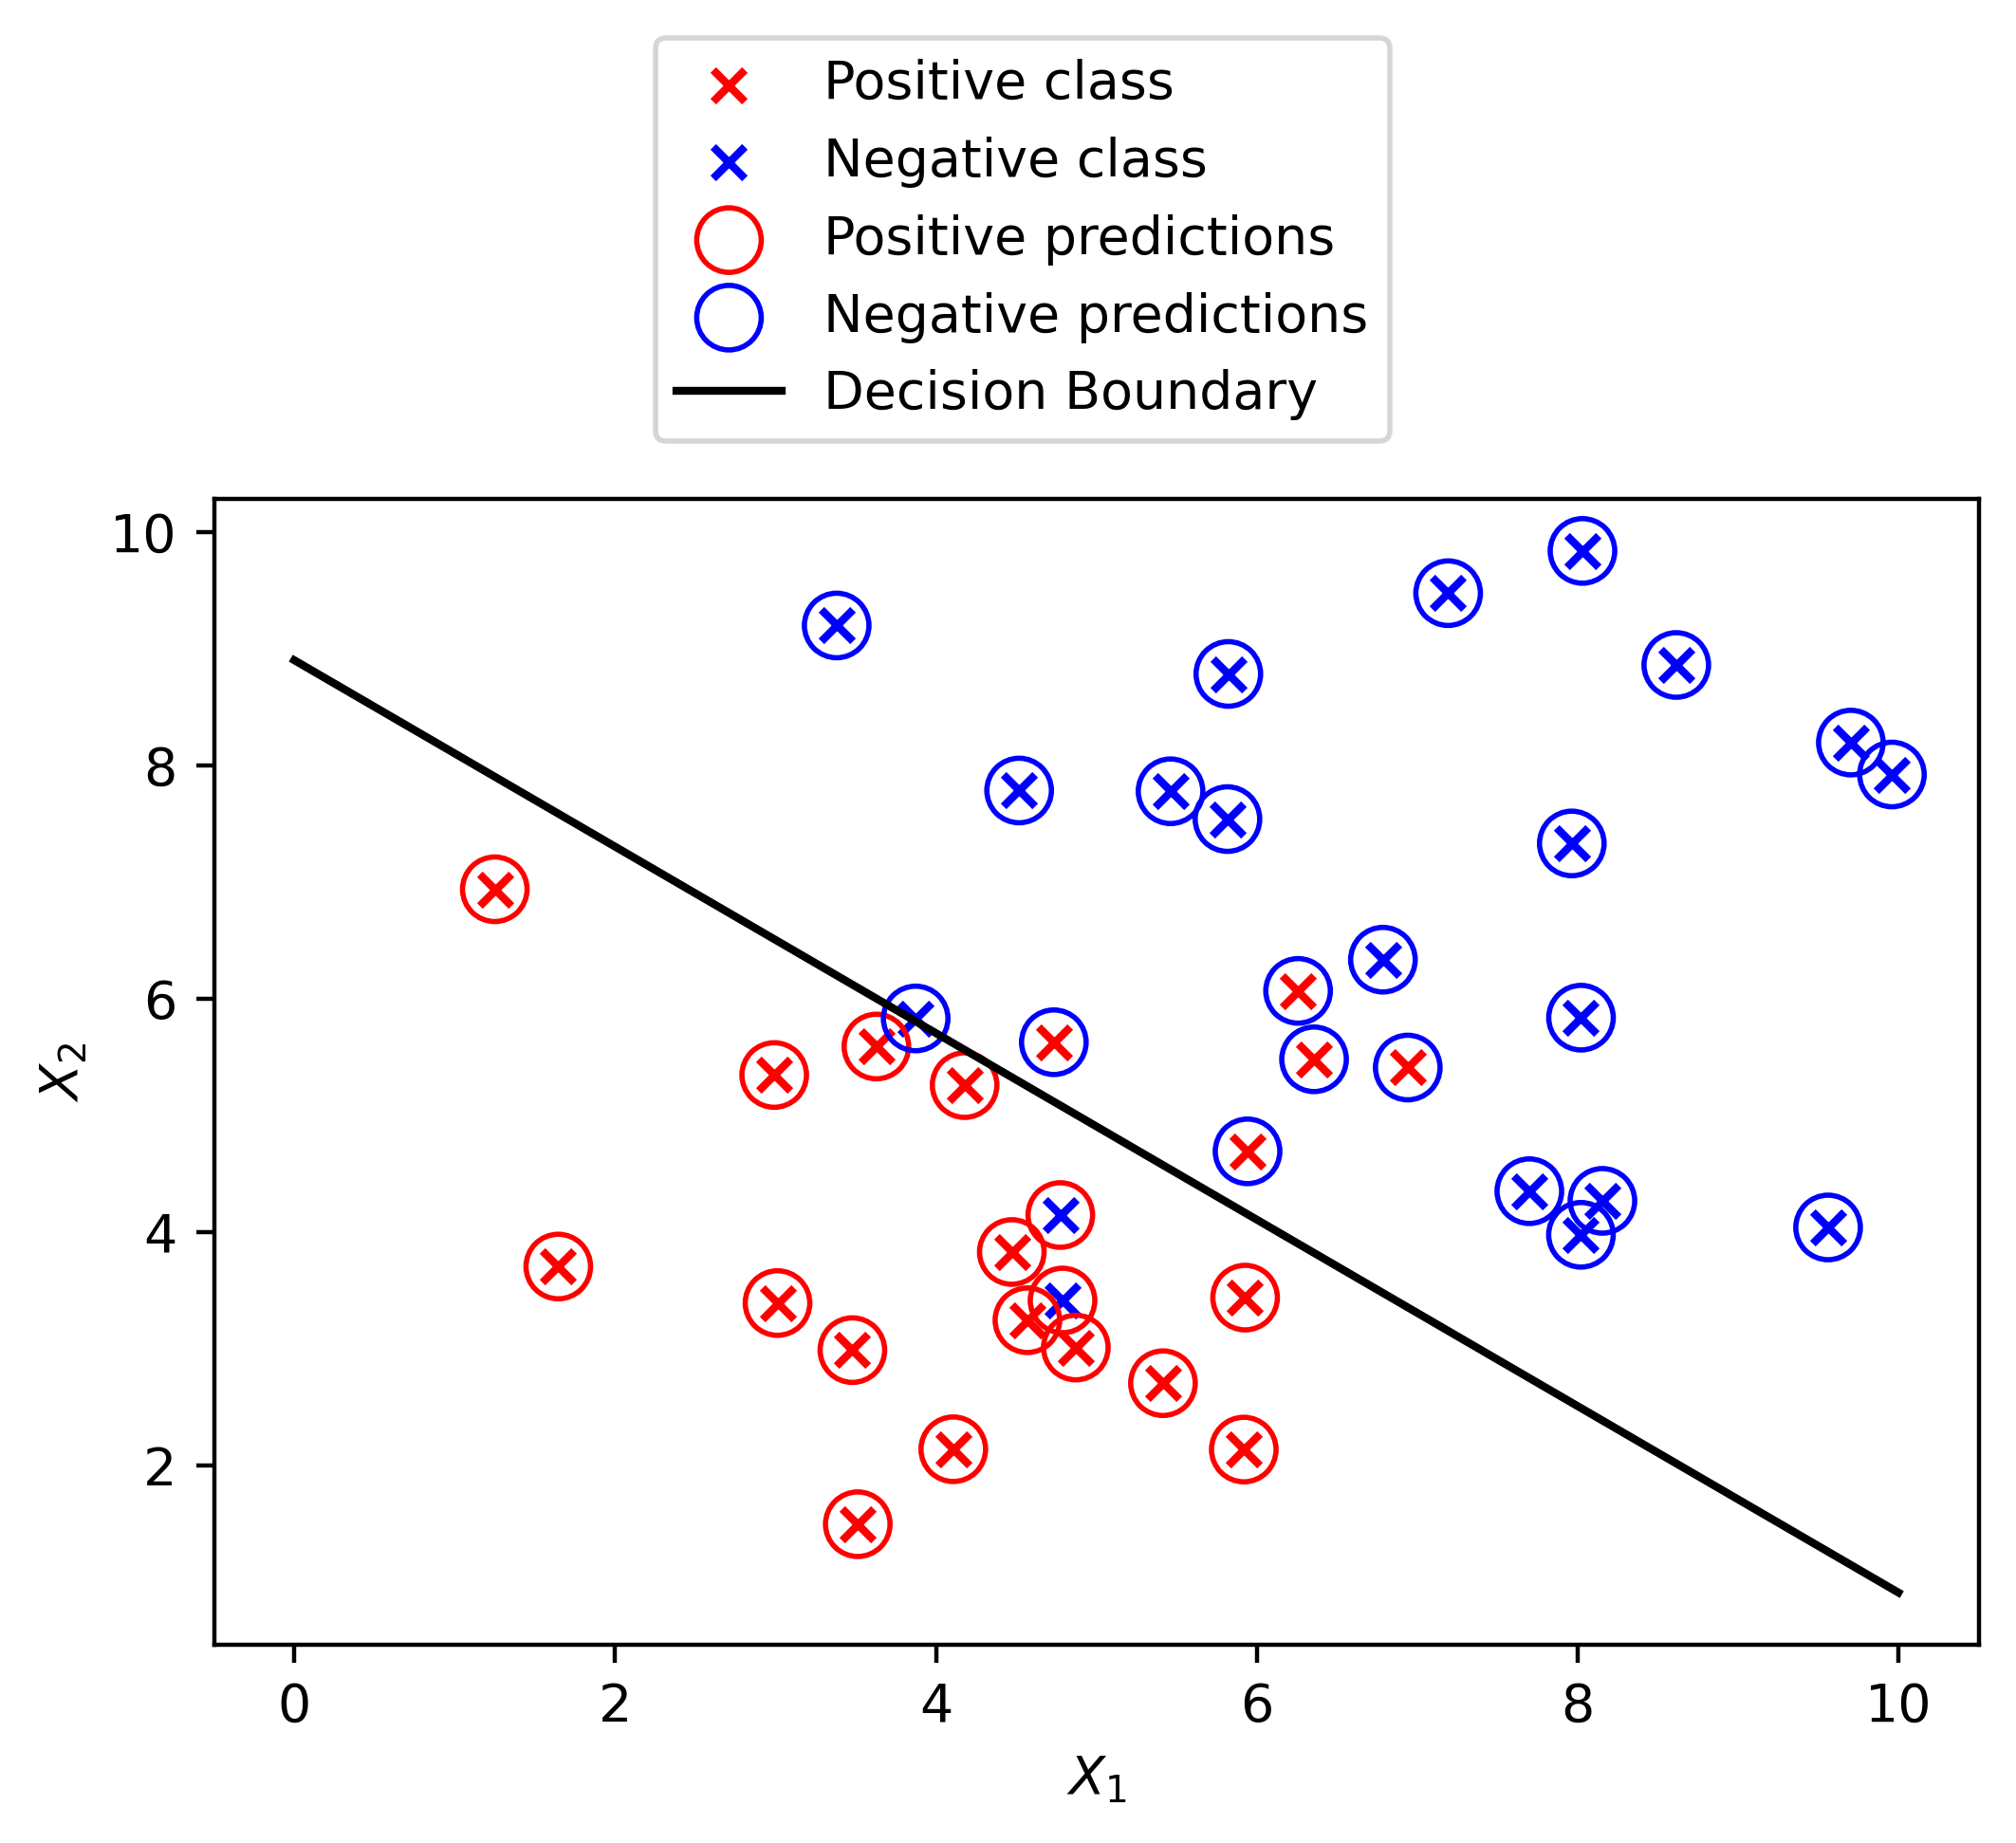

In [26]:
pos_true = plt.scatter(X_1_pos, X_2_pos, color = 'red', marker = 'x', label = 'Positive class')
neg_true = plt.scatter(X_1_neg, X_2_neg, color = 'blue', marker = 'x', label = 'Negative class')

pos_pred = plt.scatter(X[positive_indices, 0], X[positive_indices, 1], s = 150, marker = 'o', edgecolors = 'red', facecolors = 'none', label = 'Positive predictions')
neg_pred = plt.scatter(X[negative_indices, 0], X[negative_indices, 1], s = 150, marker = 'o', edgecolors = 'blue', facecolors = 'none', label = 'Negative predictions')

dec = plt.plot(X_1_decision_boundary, X_2_decision_boundary, 'k-', label = 'Decision Boundary')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(loc = [0.25, 1.05])